In [190]:
#importing libraries
import os, sys, importlib
from importlib import reload
sys.path.insert(1, '../python/')

from data_utils import *
from decode_utils import *

importlib.reload(sys.modules['data_utils'])
importlib.reload(sys.modules['decode_utils'])

from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn import svm
from sklearn.preprocessing import StandardScaler
import sklearn.ensemble
from sklearn.metrics import make_scorer
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import cross_validate

In [191]:
ls ../DataForAlexandre/ChRM04

20200521SumFluoTraceFile.mat  20200524SumFluoTraceFile.mat  Data Structure.txt
20200522SumFluoTraceFile.mat  20200525SumFluoTraceFile.mat
20200523SumFluoTraceFile.mat  20200526SumFluoTraceFile.mat


In [192]:
#specify folder and session of the experiment
folder = 'ChRM04' #ChRM04 or JawsM15 or C57_2_DualTask
session = '20200521' #20200521-6 or 20200605-09 or 20200116-20

In [193]:
#this is the fluorescence data
data = loadmat('../DataForAlexandre/' + folder + '/' + session + 'SumFluoTraceFile' + '.mat')

In [194]:
X_fluo = np.rollaxis(data['C_df'],1,0)
X_fluo_df = np.rollaxis(data['dFF0'],1,0)
X_rates = np.rollaxis(data['S_dec'],1,0)
y_labels = data['Events'].transpose()

In [195]:
print('data.shape')
print('#trials, #neuron, #frames (time)')
print(X_fluo.shape)
print(X_fluo_df.shape)
print(X_rates.shape)

print('labels.shape')
print('#labels, #trials')
print(y_labels.shape)

data.shape
#trials, #neuron, #frames (time)
(192, 1435, 121)
(192, 1435, 121)
(192, 1435, 121)
labels.shape
#labels, #trials
(9, 192)


In [196]:
print('data has nan?')
print(np.isnan(X_fluo).any())
print(np.isnan(X_fluo_df).any())
print(np.isnan(X_rates).any())
print('labels has nan?')
print(np.isnan(y_labels).any())

data has nan?
False


False
False
labels has nan?
False


In [197]:
y_trials = which_trials(y_labels, 'ND_trials')
print(y_trials.shape)
print(y_trials)

(32,)
[ 13  17  20  21  28  29  32  42  49  53  61  66  73  75  81  89  99 112
 113 117 130 131 136 143 150 152 153 158 169 171 174 177]


In [198]:
y_S1_trials = which_trials(y_labels, 'S1_D2_trials')
print(y_S1_trials.shape)
print(y_S1_trials)
y_S2_trials = which_trials(y_labels, 'S2_D2_trials')
print(y_S2_trials.shape)
print(y_S2_trials)

(16,)
[  7  12  30  35  52  54  94  95 101 107 129 142 147 161 190 191]
(16,)
[  7  12  30  35  52  54  94  95 101 107 129 142 147 161 190 191]


In [219]:
X_S1_trials = X_fluo_df[y_S1_trials]
X_S2_trials = X_fluo_df[y_S2_trials]
X_S1_trials = X_S1_trials[0:X_S2_trials.shape[0]]

print(X_S1_trials.shape)
print(X_S2_trials.shape)

X_S1_trials = bin_data(X_S1_trials,1,1)
print(X_S1_trials.shape)
X_S2_trials = bin_data(X_S2_trials,1,1)
print(X_S2_trials.shape)

(16, 1435, 121)
(16, 1435, 121)


(16, 1435, 120)


(16, 1435, 120)


In [220]:
bin_step = 1
bin_size = 1
data = X_S1_trials
i = int(data.shape[2]/bin_step)-1
print(i)
j=i-1
print(np.arange(int(i*bin_step),int(i*bin_step+bin_size)) )
print(np.arange(int(j*bin_step),int(j*bin_step+bin_size)) )

119
[119]
[118]


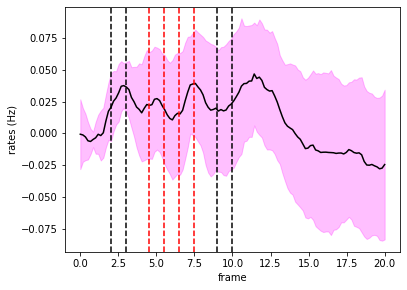

In [221]:
time = np.linspace(0,20,X_S2_trials.shape[2]);
X_window = np.mean(X_S2_trials, axis=1) # avg over neurons 
X_avg = np.mean(X_window,axis=0) # avg over trials 
X_std = np.std(X_window,axis=0) # std over trials

plt.plot(time,X_avg,c='k')
plt.fill_between(time, X_avg - X_std, X_avg + X_std, alpha=0.25, color='magenta')

plt.axvline(x=2, c='k', ls='--') # DPA sample onset 
plt.axvline(x=3, c='k', ls='--')

plt.axvline(x=9, c='k', ls='--') # DPA test onset
plt.axvline(x=10, c='k', ls='--')

plt.axvline(x=4.5, c='r', ls='--') # DRT distractor onset
plt.axvline(x=5.5, c='r', ls='--')

plt.axvline(x=6.5, c='r', ls='--') # DRT cue onset
plt.axvline(x=7.5, c='r', ls='--')

plt.xlabel('frame') ;
plt.ylabel('rates (Hz)') ;

In [222]:
#generating the labels from the length of the trials (samples)
y_S1 = np.repeat(0,int(X_S1_trials.shape[0]))
print(np.unique(y_S1, return_counts=True))

y_S2 = np.repeat(1,int(X_S1_trials.shape[0]))
print(np.unique(y_S2, return_counts=True))

y_S1_S2 = np.concatenate((y_S1, y_S2))
print(y_S1_S2)

(array([0]), array([16]))
(array([1]), array([16]))
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [223]:
#concatenating S1 and S2 by the trials
X_S1_S2 = np.concatenate((X_S1_trials, X_S2_trials), axis=0)
print(X_S1_S2.shape)

(32, 1435, 120)


In [224]:
time_window = 1
split_windows = np.array_split(X_S1_S2, X_S1_S2.shape[2]/time_window, axis=2)

In [225]:
#defining the time vector
time = np.linspace(0, X_rates.shape[2]/6, num=len(split_windows))
print(time)

[ 0.          0.16946779  0.33893557  0.50840336  0.67787115  0.84733894
  1.01680672  1.18627451  1.3557423   1.52521008  1.69467787  1.86414566
  2.03361345  2.20308123  2.37254902  2.54201681  2.71148459  2.88095238
  3.05042017  3.21988796  3.38935574  3.55882353  3.72829132  3.8977591
  4.06722689  4.23669468  4.40616246  4.57563025  4.74509804  4.91456583
  5.08403361  5.2535014   5.42296919  5.59243697  5.76190476  5.93137255
  6.10084034  6.27030812  6.43977591  6.6092437   6.77871148  6.94817927
  7.11764706  7.28711485  7.45658263  7.62605042  7.79551821  7.96498599
  8.13445378  8.30392157  8.47338936  8.64285714  8.81232493  8.98179272
  9.1512605   9.32072829  9.49019608  9.65966387  9.82913165  9.99859944
 10.16806723 10.33753501 10.5070028  10.67647059 10.84593838 11.01540616
 11.18487395 11.35434174 11.52380952 11.69327731 11.8627451  12.03221289
 12.20168067 12.37114846 12.54061625 12.71008403 12.87955182 13.04901961
 13.21848739 13.38795518 13.55742297 13.72689076 13.

In [226]:
cv = 5
model_name = 'svm_linear'
scoring = {'f_score S1': make_scorer(f1_score, average = None, labels = [0]),
       'f_score S2': make_scorer(f1_score, average = None, labels = [1])}

clf = svm.LinearSVC() #svm.SVC(kernel='rbf', random_state=1, gamma=.001, C=1)

In [227]:
S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std = cross_validate_clf(split_windows, y_S1_S2, cv, scoring, clf) ;

In [228]:
print(S1_f_score)
print('S1_f_score')
print('\nList lenght (f_score) ' + str(len(S1_f_score)))

[0.1        0.1        0.16666667 0.1        0.16666667 0.11666667
 0.18333333 0.         0.1        0.11666667 0.11666667 0.16666667
 0.16666667 0.15       0.11666667 0.11666667 0.05       0.05
 0.16666667 0.16666667 0.05       0.18333333 0.2        0.16666667
 0.11666667 0.15       0.1        0.15       0.1        0.18333333
 0.05       0.1        0.16666667 0.11666667 0.15       0.05
 0.21666667 0.1        0.11666667 0.16666667 0.1        0.16666667
 0.11666667 0.18333333 0.1        0.05       0.1        0.1
 0.16666667 0.16666667 0.05       0.13333333 0.1        0.1
 0.11666667 0.11666667 0.16666667 0.05       0.18333333 0.1
 0.1        0.21666667 0.16666667 0.05       0.18333333 0.11666667
 0.16666667 0.16666667 0.18333333 0.16666667 0.2        0.13
 0.1        0.18333333 0.16666667 0.1        0.15       0.18333333
 0.16666667 0.1        0.16666667 0.16666667 0.16666667 0.1
 0.1        0.1        0.18333333 0.16666667 0.11666667 0.11666667
 0.05       0.11666667 0.16666667 0.16666

In [229]:
#sample of the results
print('S2_f_score')
print(S2_f_score)
print('\nList lenght (f_score) ' + str(len(S2_f_score)))

S2_f_score
[0.2        0.16666667 0.1        0.16666667 0.1        0.11666667
 0.05       0.23333333 0.16666667 0.11666667 0.11666667 0.1
 0.1        0.15       0.11666667 0.11666667 0.18333333 0.18333333
 0.1        0.1        0.18333333 0.05       0.15       0.1
 0.11666667 0.15       0.16666667 0.15       0.16666667 0.05
 0.18333333 0.24666667 0.1        0.11666667 0.15       0.18333333
 0.1        0.16666667 0.11666667 0.11666667 0.16666667 0.1
 0.11666667 0.05       0.16666667 0.18333333 0.16666667 0.16666667
 0.1        0.15       0.18333333 0.1        0.16666667 0.16666667
 0.11666667 0.11666667 0.1        0.18333333 0.05       0.16666667
 0.16666667 0.1        0.1        0.18333333 0.05       0.11666667
 0.1        0.1        0.05       0.1        0.1        0.16666667
 0.16666667 0.05       0.1        0.16666667 0.15       0.05
 0.1        0.16666667 0.1        0.1        0.1        0.16666667
 0.16666667 0.16666667 0.05       0.1        0.11666667 0.11666667
 0.18333333 0.116

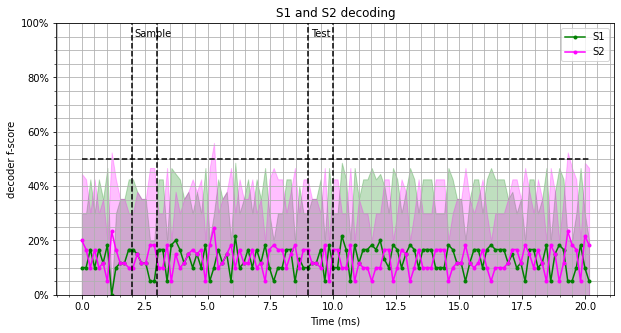

In [230]:
plot_decoding_results(S1_f_score, S2_f_score, S1_f_score_std, S2_f_score_std, time)

In [133]:
from sklearn.model_selection import train_test_split
from sklearn import svm
X = np.reshape((X_S1_S2), (X_S1_S2.shape[0], X_S1_S2.shape[1]* X_S1_S2.shape[2]))
y = y_S1_S2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.0

In [270]:
from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.60 (+/- 0.25)


In [271]:
from sklearn import metrics
scores = cross_val_score(clf, X, y, cv=5, scoring='f1_macro')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.57 (+/- 0.26)


In [272]:
from sklearn import preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_transformed = scaler.transform(X_train)
clf = svm.SVC(C=1).fit(X_train_transformed, y_train)
X_test_transformed = scaler.transform(X_test)
clf.score(X_test_transformed, y_test)

0.42857142857142855